### KDD (CIS-635) Project, Fall 2023:

# Status of Malaria in the African continent - Data Mining Insights from Heterogeneous, but Interrelated Data Sources.

By

*   *Ken Muchira*
*   *Hemalatha Sabbineni*
*   *John Moses Bollarapu*

**Abstract:** Malaria is a life-threatening mosquito-borne infectious disease, mainly caused by the
plasmodium parasites. African continent still suffers the most from this disease for many reasons
such as poverty, lack of awareness, lack of investments, insufficient infrastructure and precaution
measures, weak policy as well as management, and improper diagnosis practices. In this research,
we have performed extensive malaria data analysis for several African countries for the period 2000-
2020, and were able to extract some key insights for actionable insights. Our analysis shows that,
overall, the continent has reduced the malaria infection rate from 37% to 25% (and associated death
rates from 0.15% to 0.05%) in the last twenty years - a big achievement indeed. Unfortunately, some
countries couldn’t follow this trend, leading the progress and the development curve to be stalled
or constant and sometimes even negative for the last few years. These rates are still higher when we
compare them to other parts of the world. We were also able to make some concrete associations
with finances, associated investments, and the malaria diagnostics methodologies, adopted and
practiced by certain countries. The overall healthcare spending (as a share of the Gross Domestic
Product (GDP)) in Africa is way below the global healthcare spending as reported (5.6% vs 8.5%)
in 2000 and (5.18% vs 9.8%) in 2019 by the World Health Organization (WHO). More alarming
is, due to healthcare cuts, in recent years many countries switched from the more orthodox and
effective microscopy diagnostics tests to comparatively cheaper and less effective Rapid Diagnostic
Tests (RDTs) leading to severe consequences. We have made some concrete recommendations to
combat malaria and to reduce infection and associated mortality rates.

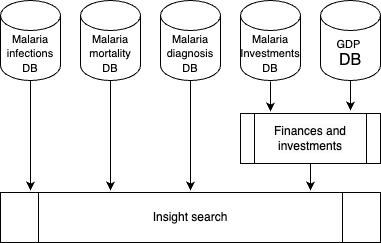


**Three major sources of data:**

- Malaria Infections (WHO)
- Malaria Related Deaths (WHO)
- Malaria Diagnosis Mehtods (WHO)
- GDA (World Bank)

## Packge Imports

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os
import numpy as np

In [ ]:
base_path = "https://raw.githubusercontent.com/mdkamrulhasan/data-public/refs/heads/main/malaria-gdp-diag-africa/2023"

In [ ]:
cases_vs_death_path = os.path.join(base_path, "casesVSDeaths.csv")
age_group_death_path = os.path.join(base_path, "malaria_deaths_age.csv")
cases_by_method_path = os.path.join(base_path, "Reported_malaria_cases_by_method.csv")
gdp_path = os.path.join(base_path, "GDP.csv")
gdp_healthcare_path = os.path.join(base_path, "HealthcareGDP.csv")
funds_govt_path = os.path.join(base_path, "fundsReportedGovns.csv")
geography_path = os.path.join(base_path, "geography.csv")

countries = sorted(['nigeria', 'kenya', 'uganda', 'burkina faso'])
years = np.arange(2000, 2020)

In [ ]:
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [ ]:
cases_vs_death = pd.read_csv(cases_vs_death_path)

In [ ]:
# formatting country names in lower case
cases_vs_death['Country_lw'] = cases_vs_death.Country.apply(lambda x: x.lower())

In [ ]:
cases_vs_death.head(2)

,Country,Year,Population,CasesLower,CasesPoint,CasesUpper,DeathsLower,DeathsPoint,DeathsUpper,Region,Country_lw
0,Algeria,2000,1823421,0,34,0,0,2,0,Africa,algeria
1,Algeria,2001,1847461,0,6,0,0,1,0,Africa,algeria


In [ ]:
# data normalzation by dividing number of infections by the total population of a country
cases_vs_death['cases_nm'] = cases_vs_death.CasesPoint / cases_vs_death.Population
cases_vs_death['deaths_nm'] = cases_vs_death.DeathsPoint / cases_vs_death.Population

In [ ]:
cases_vs_death.head(2)

,Country,Year,Population,CasesLower,CasesPoint,CasesUpper,DeathsLower,DeathsPoint,DeathsUpper,Region,Country_lw,cases_nm,deaths_nm
0,Algeria,2000,1823421,0,34,0,0,2,0,Africa,algeria,0.000019,1.096839e-06
1,Algeria,2001,1847461,0,6,0,0,1,0,Africa,algeria,0.000003,5.412834e-07


In [ ]:
cases_vs_death.Region.unique(), cases_vs_death.Country.nunique()

(array(['Africa'], dtype=object), 44)

# Yearly statistics (Continent of Africa)

In [ ]:
# (Region, Year) deaths
deaths_region_year = cases_vs_death.groupby(['Region', 'Year']).agg({'DeathsPoint': 'sum',
                                                                     'CasesPoint': 'sum',
                                                                     'Population': 'sum'})
# data normalzation
deaths_region_year['deaths_nm'] = deaths_region_year.DeathsPoint / deaths_region_year.Population
deaths_region_year['cases_nm'] = deaths_region_year.CasesPoint / deaths_region_year.Population
deaths_region_year = deaths_region_year.reset_index()
deaths_region_year_africa = deaths_region_year[deaths_region_year.Region.isin(['Africa'])]

In [ ]:
deaths_region_year.head(2)

,Region,Year,DeathsPoint,CasesPoint,Population,deaths_nm,cases_nm
0,Africa,2000,839720,206651695,561458148,0.001496,0.368063
1,Africa,2001,837574,212231714,576884826,0.001452,0.367893


In [ ]:
# plotting the infection freq by year
px.bar(x=deaths_region_year_africa.Year, y=deaths_region_year_africa.CasesPoint,
       title='Malaria cases over Years (Africa)')

Comment: Number of infections is quite constant over years; infact, we see an increase in the last few years.

TS modeling (facebook prophet)

In [ ]:
deaths_region_year.head()

,Region,Year,DeathsPoint,CasesPoint,Population,deaths_nm,cases_nm
0,Africa,2000,839720,206651695,561458148,0.001496,0.368063
1,Africa,2001,837574,212231714,576884826,0.001452,0.367893
2,Africa,2002,796770,208976813,592773968,0.001344,0.352540
3,Africa,2003,773523,211050443,609187857,0.001270,0.346446
4,Africa,2004,749959,212123003,626203574,0.001198,0.338744


In [ ]:
!pip install prophet

In [ ]:
import prophet
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go

In [ ]:
# data splitting
TRR_YEAR_TH = 2015
TIME_INDEX_COLUMN_NAME = 'Year'
TARGET_VARIABLE_COLUMN_NAME = 'CasesPoint'

df_train = deaths_region_year[deaths_region_year.Year <= TRR_YEAR_TH]
df_test = deaths_region_year[deaths_region_year.Year > TRR_YEAR_TH]
df_train.shape, df_test.shape

((16, 7), (5, 7))

In [ ]:
df_train.head(2)

,Region,Year,DeathsPoint,CasesPoint,Population,deaths_nm,cases_nm
0,Africa,2000,839720,206651695,561458148,0.001496,0.368063
1,Africa,2001,837574,212231714,576884826,0.001452,0.367893


In [ ]:
model = prophet.Prophet()
model.fit(df_train.rename(columns={TIME_INDEX_COLUMN_NAME:'ds', TARGET_VARIABLE_COLUMN_NAME:'y'}))
train_forecast = model.predict(df_train.rename(columns={TIME_INDEX_COLUMN_NAME:'ds', TARGET_VARIABLE_COLUMN_NAME:'y'}))
test_forecast = model.predict(df_test.rename(columns={TIME_INDEX_COLUMN_NAME:'ds', TARGET_VARIABLE_COLUMN_NAME:'y'}))
mean_absolute_error(df_train.CasesPoint.values, train_forecast.yhat), mean_absolute_error(df_test.CasesPoint.values, test_forecast.yhat)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj1pwbrcr/_lej4mhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj1pwbrcr/yypuegpq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61456', 'data', 'file=/tmp/tmpj1pwbrcr/_lej4mhu.json', 'init=/tmp/tmpj1pwbrcr/yypuegpq.json', 'output', 'file=/tmp/tmpj1pwbrcr/prophet_modeld4nyt_jg/prophet_model-20240923015723.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:57:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:57:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:

(1243815.8984617088, 13232694.16739496)

In [ ]:
start_year = 2021
nb_of_future_years = 5
unseen_data = pd.DataFrame({TIME_INDEX_COLUMN_NAME: np.arange(
    start_year, start_year + nb_of_future_years),
                            TARGET_VARIABLE_COLUMN_NAME:[-1]* nb_of_future_years})
unseen_data[TIME_INDEX_COLUMN_NAME] = unseen_data[TIME_INDEX_COLUMN_NAME].astype(float)
unseen_data[TIME_INDEX_COLUMN_NAME].min(), unseen_data[TIME_INDEX_COLUMN_NAME].max()

(2021.0, 2025.0)

In [ ]:
# to add datetime column
deaths_region_year['ds'] = pd.to_datetime(deaths_region_year[TIME_INDEX_COLUMN_NAME])
unseen_data['ds'] = pd.to_datetime(unseen_data[TIME_INDEX_COLUMN_NAME])

In [ ]:
# train on all data and forecast on unseen data
model = prophet.Prophet()
model.fit(deaths_region_year.rename(columns={TARGET_VARIABLE_COLUMN_NAME:'y'}))
train_forecast = model.predict(deaths_region_year.rename(columns={TARGET_VARIABLE_COLUMN_NAME:'y'}))
unseen_forecast = model.predict(unseen_data.rename(columns={TARGET_VARIABLE_COLUMN_NAME:'y'}))
mean_absolute_error(deaths_region_year[TARGET_VARIABLE_COLUMN_NAME].values, train_forecast.yhat)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj1pwbrcr/mk9zui8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj1pwbrcr/iqllinnf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39154', 'data', 'file=/tmp/tmpj1pwbrcr/mk9zui8h.json', 'init=/tmp/tmpj1pwbrcr/iqllinnf.json', 'output', 'file=/tmp/tmpj1pwbrcr/prophet_modelditp_unw/prophet_model-20240923015724.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:57:24 - cmdstanpy - INFO - Chain [1] start processing
I

2329258.3167184223

In [ ]:
# extracting year information
train_forecast[TIME_INDEX_COLUMN_NAME] = train_forecast['ds'].apply(lambda x: str(x)[-4:])
unseen_forecast[TIME_INDEX_COLUMN_NAME ] = unseen_forecast['ds'].apply(lambda x: str(x)[-4:])
train_forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Year
0,1970-01-01 00:00:00.000002000,2.107330e+08,2.067002e+08,2.149972e+08,2.107330e+08,2.107330e+08,0.0,0.0,0.0,0.0,0.0,0.0,2.107330e+08,0002
1,1970-01-01 00:00:00.000002001,2.104889e+08,2.067456e+08,2.148532e+08,2.104889e+08,2.104889e+08,0.0,0.0,0.0,0.0,0.0,0.0,2.104889e+08,2001


# Creating dataframe for visualization

In [ ]:
deaths_region_year[TIME_INDEX_COLUMN_NAME] = deaths_region_year[TIME_INDEX_COLUMN_NAME].astype(float)
train_forecast[TIME_INDEX_COLUMN_NAME] = train_forecast[TIME_INDEX_COLUMN_NAME].astype(float)
unseen_forecast[TIME_INDEX_COLUMN_NAME] = unseen_forecast[TIME_INDEX_COLUMN_NAME].astype(float)

In [ ]:
deaths_region_year.head(2)

,Region,Year,DeathsPoint,CasesPoint,Population,deaths_nm,cases_nm,ds
0,Africa,2000.0,839720,206651695,561458148,0.001496,0.368063,1970-01-01 00:00:00.000002000
1,Africa,2001.0,837574,212231714,576884826,0.001452,0.367893,1970-01-01 00:00:00.000002001


In [ ]:
deaths_region_year['data_src'] = 'base'
train_forecast['data_src'] = 'forecasted'
unseen_forecast['data_src'] = 'forecasted'

In [ ]:
min_column_list = ['data_src', TIME_INDEX_COLUMN_NAME, TARGET_VARIABLE_COLUMN_NAME]
dtf = pd.concat([deaths_region_year[min_column_list],
                               train_forecast.rename(
                                   columns={'yhat':TARGET_VARIABLE_COLUMN_NAME})[min_column_list],
                               unseen_forecast.rename(
                                   columns={'yhat':TARGET_VARIABLE_COLUMN_NAME})[min_column_list],
                               ], axis=0)

In [ ]:
deaths_region_year.Year.min()

2000.0

In [ ]:
dtf[dtf.data_src == 'forecasted'].Year.min(), dtf[dtf.data_src == 'forecasted'].Year.max()

(2.0, 2025.0)

# Model training & prediction data visualization

In [ ]:
TRR_MIN_YEAR = deaths_region_year.Year.min()
TRR_MAX_YEAR = deaths_region_year.Year.max()
fig = go.Figure([go.Scatter(x=dtf[(dtf.data_src == 'base')& (dtf[TIME_INDEX_COLUMN_NAME] < start_year)][TIME_INDEX_COLUMN_NAME],
                            y=dtf[(dtf.data_src == 'base')& (dtf[TIME_INDEX_COLUMN_NAME] < start_year)][TARGET_VARIABLE_COLUMN_NAME], name='training data'),
                 go.Scatter(x=dtf[(dtf.data_src == 'forecasted') &
                  (dtf[TIME_INDEX_COLUMN_NAME] < start_year) &
                   (dtf[TIME_INDEX_COLUMN_NAME] > TRR_MIN_YEAR)][TIME_INDEX_COLUMN_NAME],
                            y=dtf[(dtf.data_src == 'forecasted')&
                             (dtf[TIME_INDEX_COLUMN_NAME] < start_year) &
                              (dtf[TIME_INDEX_COLUMN_NAME] > TRR_MIN_YEAR)][TARGET_VARIABLE_COLUMN_NAME], name='forecasted (training data)'),
                                   go.Scatter(x=dtf[(dtf.data_src == 'forecasted') &
                  (dtf[TIME_INDEX_COLUMN_NAME] >= TRR_MAX_YEAR)][TIME_INDEX_COLUMN_NAME],
                            y=dtf[(dtf.data_src == 'forecasted')&
                             (dtf[TIME_INDEX_COLUMN_NAME] >= TRR_MAX_YEAR)][TARGET_VARIABLE_COLUMN_NAME], name='forecasted (unseen data)'),
                 ])
fig.update_layout(
    title="Forecasting malaria infections (facebook prophet)",
    yaxis_title="malaria infection frequency",
    legend_title="")

fig.update_layout(
    autosize=True,
    legend=dict(
        x=0.85,
        y=0.09,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)
fig.show()

In [ ]:
nb_years = dtf[(dtf.data_src == 'forecasted')& (dtf[TIME_INDEX_COLUMN_NAME] >= TRR_MAX_YEAR)][TIME_INDEX_COLUMN_NAME].nunique()
nb_infections = dtf[(dtf.data_src == 'forecasted')& (dtf[TIME_INDEX_COLUMN_NAME] >= TRR_MAX_YEAR)][TARGET_VARIABLE_COLUMN_NAME].sum()
avg_infections_per_year = dtf[(dtf.data_src == 'forecasted')& (dtf[TIME_INDEX_COLUMN_NAME] >= TRR_MAX_YEAR)][TARGET_VARIABLE_COLUMN_NAME].mean()

In [ ]:
print('In {} years, starting from {}, an estimated {} number of people in \
Africa is going to infected with Malaria'.format(nb_years, int(TRR_MAX_YEAR + 1)
, int(nb_infections)))

In 6 years, starting from 2021, an estimated 1351775826 number of people in Africa is going to infected with Malaria


In [ ]:
print('On average {} infections per year'.format(int(avg_infections_per_year)))

On average 225295971 infections per year
